In [1]:
import numpy as np
import tensorflow as tf
import glob
import random
from sklearn import model_selection

from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation, Input, Flatten
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle
import keras
from sklearn.metrics import f1_score
import cv2

import os
import shutil

In [9]:
def trainClasses():
    trainClasses = set()
    with open("trainclasses.txt") as f:
        for line in f:
            trainClasses.add(line.strip())

    idxToClass = {}
    with open("classes.txt") as f:
        for line in f:
            idx, cname = line.strip().split("\t")
            idxToClass[int(idx)] = cname
    
    print("reading IO")
    
    classToY = {}
    with open("predicate-matrix-binary.txt") as f:
        for idx, line in enumerate(f):
            cname = idxToClass[idx+1]
            if cname in trainClasses:
                classToY[cname] = list(map(int, line.strip().split()))
                
    kaze = cv2.KAZE_create()
    kaze_vectors = {}
    descriptor_list = []
    
    X = []
    Y = []
    for className in trainClasses:
        print(className)
        features = []
        yvec = classToY[className]
        DATA_DIR = './animalPics/' + className
        for idx, filename in enumerate(os.listdir(DATA_DIR)):
            with open(os.path.join(DATA_DIR, filename), 'r') as f:
                npimg = np.fromfile(f, np.uint8)
                cvimg = cv2.imdecode(npimg, cv2.IMREAD_COLOR)
                finalimg = cv2.resize(cvimg, (299, 299))
                if idx < 14:
                    try:
                        kp, des = kaze.detectAndCompute(finalimg, None)
                        descriptor_list.extend(des)
                        features.append(des)
                    except:
                        continue
                X.append(finalimg)
                Y.append(yvec)
                
        kaze_vectors[className] = features
    
    X = np.array(X)
    Y = np.array(Y)

    print(X.shape)
    print(Y.shape)
    
    return X, Y, idxToClass, kaze_vectors, descriptor_list

In [10]:
X, Y, idxToClass, kaze_vectors, descriptor_list = trainClasses()

reading IO
zebra
buffalo
horse
blue+whale
weasel
deer
bobcat
walrus
bat
cow
grizzly+bear
antelope
chihuahua
giraffe
rhinoceros
german+shepherd
gorilla
elephant
hamster
rabbit
siamese+cat
killer+whale
mole
squirrel
dalmatian
ox
moose
otter
tiger
beaver
skunk
mouse
wolf
dolphin
fox
lion
collie
spider+monkey
sheep
polar+bear
(30337, 299, 299, 3)
(30337, 85)


In [11]:
# A k-means clustering algorithm who takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=5)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words, kmeans
    
# Takes the central points which is visual words    
visual_words, model = kmeans(2000, descriptor_list) 

In [ ]:
hists = []
classes1 = []
KAZE = cv.KAZE_create()

for key,value in images.items():
    for img in value:
        try:
            kp, des = KAZE.detectAndCompute(img,None)
            des_double = np.array(des, dtype=np.double)
            predict_kmeans = model.predict(des_double)
            #calculates the histogram
            hist, bin_edges = np.histogram(predict_kmeans, bins=2000)
            hists.append(hist)
            classes1.append(key)
        except:
            continue

{'ground', 'big', 'grazer', 'longneck', 'agility', 'plains', 'group', 'chewteeth', 'fast', 'fields', 'quadrapedal', 'stripes', 'active', 'strong', 'furry', 'longleg', 'walks', 'black', 'forager', 'timid', 'oldworld', 'hooves', 'bush', 'toughskin', 'tail', 'lean', 'white', 'muscle', 'vegetation', 'smart'}

{'ground', 'big', 'grazer', 'longneck', 'agility', 'plains', 'group', 'chewteeth', 'fast', 'fields', 'quadrapedal', 'stripes', 'active', 'strong', 'furry', 'longleg', 'walks', 'black', 'forager', 'timid', 'oldworld', 'hooves', 'bush', 'toughskin', 'tail', 'lean', 'white', 'muscle', 'vegetation', 'smart'}

{'ground', 'big', 'grazer', 'brown', 'plains', 'group', 'bulbous', 'chewteeth', 'horns', 'fast', 'quadrapedal', 'strong', 'furry', 'newworld', 'walks', 'forager', 'black', 'hooves', 'inactive', 'toughskin', 'slow', 'muscle', 'fierce', 'vegetation', 'smelly'}

{'ground', 'big', 'grazer', 'buckteeth', 'brown', 'longneck', 'agility', 'plains', 'group', 'chewteeth', 'fast', 'fields', 'qu

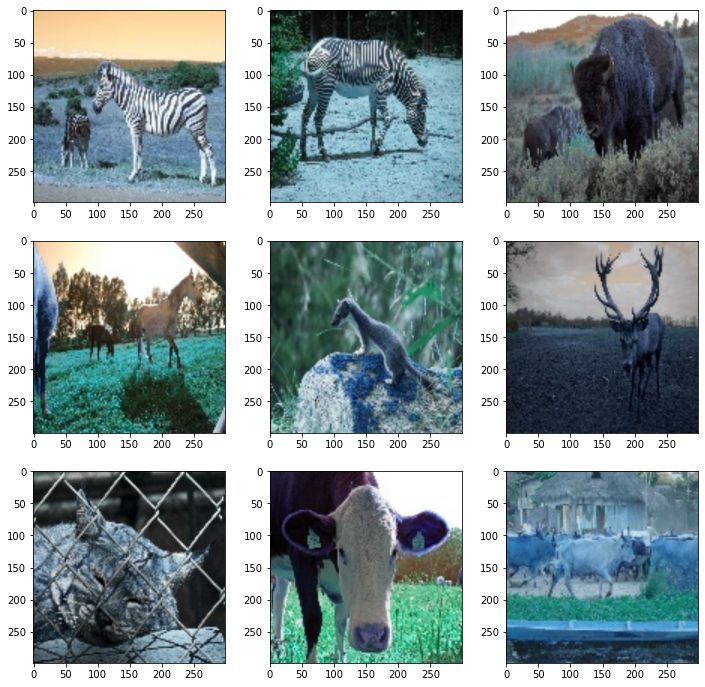

In [13]:
attributeDict = {}

with open("predicates.txt") as f:
    for line in f:
        idx, att = line.strip().split()
        attributeDict[int(idx) - 1] = att
        
def getAttributeList(y):
    attSet = set()
    for i, val in enumerate(y):
        if val == 1:
            attSet.add(attributeDict[i])
    print(attSet)
    print()

fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
for i in range(9):
    draws[i].imshow(X[i*1000])
    getAttributeList(Y[i*1000])

In [35]:
new_input = Input(shape=(299, 299, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=new_input)

# """
# Freeze all inception layers
# """
# for layer in inception_model.layers:
#     layer.trainable = False

x = inception_model.layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
prediction = Dense(85, activation='sigmoid')(x)

model = Model(inputs=inception_model.input, outputs=prediction)

model.summary()

batch_size = 32

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_658 (Conv2D)             (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_658 (BatchN (None, 149, 149, 32) 96          conv2d_658[0][0]                 
__________________________________________________________________________________________________
activation_658 (Activation)     (None, 149, 149, 32) 0           batch_normalization_658[0][0]    
____________________________________________________________________________________________

In [36]:
top_epochs = 3

model.fit(X, Y, batch_size = batch_size, epochs = top_epochs, shuffle=True)

Epoch 1/3
519/949 [===============>..............] - ETA: 40:26 - loss: 0.3043 - binary_accuracy: 0.8658

KeyboardInterrupt: 

In [30]:
x_sample = X[0].reshape((-1, 299, 299, 3))
y_pred = model.predict(x_sample)
print(y_pred)
print(model.predict(X[1500].reshape((-1, 299, 299, 3))))
print(Y[0])
print(Y[1500])

[[0.6139071  0.43283182 0.28757548 0.6633914  0.35081625 0.29165098
  0.2849313  0.2934349  0.44536793 0.38460785 0.3013232  0.7077265
  0.2989602  0.65974355 0.6925604  0.31074905 0.38965818 0.6115739
  0.2917624  0.28475744 0.65219826 0.29652518 0.32117566 0.51498336
  0.43061495 0.6663348  0.7017992  0.33851844 0.32127416 0.2889619
  0.46808076 0.3315165  0.28869432 0.4810981  0.28982195 0.28821808
  0.2939807  0.2899782  0.7022011  0.69270366 0.3907192  0.7016894
  0.2949139  0.6867001  0.30307096 0.70292485 0.6916236  0.4132282
  0.3114763  0.32040036 0.61127275 0.30532506 0.3289129  0.28780502
  0.66568136 0.2906806  0.6199135  0.65307647 0.32989204 0.29104358
  0.28791952 0.3116137  0.6933321  0.67791116 0.29226452 0.28958526
  0.285581   0.30527824 0.67163914 0.3904396  0.6263711  0.2946329
  0.4405358  0.29206312 0.70203185 0.2912731  0.3009949  0.3158635
  0.36828983 0.633797   0.6223401  0.6805417  0.3263933  0.32331234
  0.3613153 ]]
[[0.6139071  0.43283182 0.28757548 0.663

In [160]:
def testClasses():
    fileList = []
    fileToLabel = {}
    with open("test_images.txt") as f:
        for line in f:
            path, label = line.strip().split()
            fileToLabel[path] = label
            fileList.append(path)
    
    testClasses = set()
    with open("testclasses.txt") as f:
        for line in f:
            testClasses.add(line.strip())
    
    classToY = {}
    with open("predicate-matrix-binary.txt") as f:
        for idx, line in enumerate(f):
            cname = idxToClass[idx+1]
            if cname in testClasses:
                classToY[cname] = list(map(int, line.strip().split()))
                
    X_test = []
    Y_test = []
    for file, label in fileToLabel.items():
        DATA_DIR = './animalPics/' + file
        with open(DATA_DIR, 'r') as f:
            npimg = np.fromfile(f, np.uint8)
            cvimg = cv2.imdecode(npimg, cv2.IMREAD_COLOR)
            X_test.append(cv2.resize(cvimg, (299, 299)))
            Y_test.append(classToY[label])
    
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    
    return X_test, Y_test, classToY, fileList

In [161]:
X_test, Y_test, classToY, fileList = testClasses()

In [79]:
def predict():
    print("predicting test data")
    y_pred = model.predict(X_test)
    
    print("choosing nearest neighbor")
    class_pred = []
    for i in range(len(y_pred)):
        yvec = y_pred[i]
        
        minDiff = 1000000000000000
        minName = "empty"
            
        for cname, Y in classToY.items():
            diff = np.sum(np.square(np.abs(Y - yvec)))
            if diff < minDiff:
                minDiff = diff
                minName = cname
                
        class_pred.append(minName)
    return class_pred

In [197]:
class_predict = predict()

predicting test data
choosing nearest neighbor


In [95]:
def printFile():
    outFile = "submission.txt"
    with open(outFile, 'w') as f:
        for i in range(len(class_predict)):
            f.write(fileList[i] + " " + class_predict[i] + "\n")
        

In [198]:
printFile()